<a href="https://colab.research.google.com/github/yichichandesu/short-term-volatility/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Set-Up and Configuration

In [ ]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path
from google.colab import drive
import time
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths
BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/crypto_data')
MONARQ_PATH = BASE_PATH / 'monarq_data'
FUNDING_PATH = BASE_PATH / 'processed_funding' # Where we saved the funding parquets earlier
OUTPUT_PATH = BASE_PATH / 'processed_final'    # Where we will save the final features

# Create output directory
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# 3. Define Symbols & Constants
TARGET_SYMBOLS = ["BTCUSDT", "ETHUSDT"]
DATA_TYPES = ["trade_1min", "level1_1min", "book_1min", "openinterest_1min"]
TYPE_PREFIX = {
    "trade_1min": "tr",
    "level1_1min": "l1",
    "book_1min": "l2",
    "openinterest_1min": "oi"
}

# 4. Processed Parquet Files Check
processed_funding_check = True
processed_final_check = True

print(f"Reading Raw Data from: {MONARQ_PATH}")
print(f"Saving Parquets to: {OUTPUT_PATH}")

Mounted at /content/drive
Reading Raw Data from: /content/drive/MyDrive/Colab Notebooks/crypto_data/monarq_data
Saving Parquets to: /content/drive/MyDrive/Colab Notebooks/crypto_data/processed_final


In [ ]:

import torch
import torch.nn as nn

class VolatilityLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        """
        Args:
            input_size (int): Number of features (e.g., 10 tech indicators).
            hidden_size (int): Number of neurons in the LSTM hidden state.
            num_layers (int): Number of stacked LSTM layers.
            output_size (int): Number of values to predict (usually 1 for volatility).
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(VolatilityLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. The LSTM Layer
        # batch_first=True means input shape is (Batch, Seq_Len, Features)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )

        # 2. The Fully Connected (Linear) Layer
        # Maps the hidden state to the final volatility output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward propagate LSTM
        # out shape: (Batch_Size, Seq_Length, Hidden_Size)
        out, _ = self.lstm(x)

        # Decode the hidden state of the last time step
        # We only care about the final prediction after seeing the whole window
        last_time_step_out = out[:, -1, :]

        # Pass through the Linear layer to get the final prediction
        prediction = self.fc(last_time_step_out)

        return prediction

# 1. Microstructure Processor

In [ ]:
def process_microstructure_and_save(symbol):
    print(f"\n=== Processing Microstructure: {symbol} ===")

    # 1. Load and Merge Raw Data Types (Trade, L1, L2, OI)
    dfs = []
    for dt in DATA_TYPES:
        folder = MONARQ_PATH / dt / symbol
        prefix = TYPE_PREFIX.get(dt, dt)
        files = sorted(folder.glob("*.csv.gz"))

        if not files: continue

        type_dfs = []
        for f in files:
            try:
                temp = pd.read_csv(f)
                type_dfs.append(temp)
            except: pass

        if type_dfs:
            df_type = pd.concat(type_dfs, ignore_index=True)
            if "ts_end" in df_type.columns:
                df_type["ts_end"] = pd.to_datetime(df_type["ts_end"], unit="ms", utc=True)
                df_type = df_type.sort_values("ts_end").set_index("ts_end")
                df_type = df_type[~df_type.index.duplicated(keep="last")]
                df_type = df_type.rename(columns={c: f"{prefix}__{c}" for c in df_type.columns})
                dfs.append(df_type)

    if not dfs: return False

    print("Joining data types...")
    df = dfs[0]
    for d in dfs[1:]:
        df = df.join(d, how="outer")

    df = df.sort_index()

    # ==============================================================================
    # 2. FULL FEATURE ENGINEERING
    # ==============================================================================
    print("   Calculating ALL Features...")
    eps = 1e-8

    # --- A. Basic Price/Vol ---
    df["dt"] = df.index
    df["symbol"] = symbol
    if "tr__close_price" in df.columns:
        df["ret_1m"] = df["tr__close_price"].pct_change()
        df["abs_ret_1m"] = df["ret_1m"].abs()
        df["rv_30m"] = df["ret_1m"].pow(2).rolling(30, min_periods=10).sum()

    if "tr__volume" in df.columns:
        df["log_volume"] = np.log1p(df["tr__volume"].astype(float))

    # --- B. Order Flow Imbalance (OFI) ---
    if "tr__buy_volume" in df.columns and "tr__sell_volume" in df.columns:
        df["OFI_raw"] = df["tr__buy_volume"] - df["tr__sell_volume"]

        # OFI Derived Features
        df["OFI_std_30m"] = df["OFI_raw"].rolling(30, min_periods=10).std()

        ofi_lag10 = df["OFI_raw"].shift(10)
        df["OFI_roc_10m"] = (df["OFI_raw"] - ofi_lag10) / (ofi_lag10.abs() + eps)

        # VPIN Proxy (Volume-Synchronized Probability of Informed Trading)
        buy_v = df["tr__buy_volume"]
        sell_v = df["tr__sell_volume"]
        df["VPIN_proxy"] = (buy_v - sell_v).abs() / (buy_v + sell_v + eps)

    # --- C. L1 Order Book Features ---
    if "l1__close_bid_size" in df.columns:
        bid_sz = df["l1__close_bid_size"]
        ask_sz = df["l1__close_ask_size"]
        df["L1_Imbalance"] = (bid_sz - ask_sz) / (bid_sz + ask_sz + eps)

        # Liquidity Weighted OFI
        if "OFI_raw" in df.columns:
            depth = df.get("l1__mean_bid_size", 0) + df.get("l1__mean_ask_size", 0)
            df["Liquidity_Weighted_OFI"] = df["OFI_raw"] * depth

    if "l1__mean_spread" in df.columns:
        df["Mean_Spread"] = df["l1__mean_spread"]
        df["Spread_ma_15m"] = df["l1__mean_spread"].rolling(15, min_periods=5).mean()

    # --- D. Advanced Microstructure ---
    # VWAP Deviation
    if "tr__vwap" in df.columns and "tr__close_price" in df.columns:
        df["VWAP_deviation"] = (df["tr__vwap"] - df["tr__close_price"]) / (df["tr__close_price"] + eps)

    # Trade Intensity
    if "tr__trade_count" in df.columns:
        df["Trade_Intensity"] = df["tr__trade_count"]

    # Price Impact
    if "tr__close_price" in df.columns and "tr__volume" in df.columns:
        ret_15m = df["tr__close_price"].pct_change(15)
        vol_15m = df["tr__volume"].rolling(15, min_periods=5).sum()
        df["Price_Impact_per_Volume"] = ret_15m.abs() / (vol_15m + eps)

    # --- E. L2 Order Book (Depth Ratios) ---
    # Only if Level 2 data exists
    if "l2__bid_10000K_fill_dsize" in df.columns:
        b_10m = df["l2__bid_10000K_fill_dsize"]
        a_10m = df["l2__ask_10000K_fill_dsize"]
        df["depth_ratio_10M"] = b_10m / (a_10m + eps)
        df["l2_imbalance_10M"] = (b_10m - a_10m) / (b_10m + a_10m + eps)

    # ==============================================================================
    # 3. SAVE TO PARQUET
    # ==============================================================================
    out_file = OUTPUT_PATH / f"{symbol}_micro_features.parquet"
    df.to_parquet(out_file)
    print(f"Saved {len(df)} rows to {out_file.name} (With ALL features)")

    # 4. Clean Memory
    del df
    del dfs
    gc.collect()
    return True

if not processed_funding_check:
  # --- RUN THE UPDATE ---
  for sym in TARGET_SYMBOLS:
      process_microstructure_and_save(sym)

# 3. Merging Dataset

In [ ]:
def finalize_dataset(symbol):
    print(f"\n=== Finalizing {symbol} ===")

    # 1. Load Microstructure Features
    micro_file = OUTPUT_PATH / f"{symbol}_micro_features.parquet"
    if not micro_file.exists():
        print(f"Missing microstructure file for {symbol}")
        return

    df = pd.read_parquet(micro_file)

    # 2. Load and Merge Funding Rate
    fund_file = FUNDING_PATH / f"{symbol}_funding_clean.parquet"

    if fund_file.exists():
        funding_df = pd.read_parquet(fund_file)

        # Resample Funding to 1-min (Forward Fill)
        funding_df = funding_df.set_index("dt").sort_index()
        funding_1min = funding_df["rate"].resample("1min").ffill().to_frame("funding_rate")

        # Merge onto main dataframe
        # Ensure df has datetime index or column 'dt'
        if "dt" in df.columns:
            df = df.set_index("dt")

        df = df.join(funding_1min, how="left")
        print("gw Funding rate merged.")
    else:
        print("Funding file not found, filling NaNs.")
        df["funding_rate"] = np.nan

    # 3. Create Targets (Future Volatility)
    # Target: Realized Volatility 5 mins into the future
    if "ret_1m" in df.columns:
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
        df["rv_fwd_5m"] = df["ret_1m"].pow(2).rolling(window=indexer).sum().pow(0.5)
        print("Target (rv_fwd_5m) created.")

        # Create Lags (e.g., Volatility 5 mins ago)
        df["rv_30m_lag5"] = df["rv_30m"].shift(5)

    # 4. Save FINAL Dataset
    final_file = OUTPUT_PATH / f"{symbol}_final_train.parquet"
    df.to_parquet(final_file)
    print(f"Saved Final: {final_file.name}")

    # 5. Purge
    del df
    gc.collect()

if not processed_final_check:
  # --- RUN PHASE 2 ---
  for sym in TARGET_SYMBOLS:
      finalize_dataset(sym)

# 4. LSTM Data Preparation

In [ ]:
def load_training_data(symbol):
    """
    Loads the finalized parquet file for symbol
    """

    file_path = OUTPUT_PATH / f"{symbol}_final_train.parquet"

    if file_path.exists():
        print(f"   Reading parquet: {file_path.name}")
        return pd.read_parquet(file_path)
    else:
        print(f"   Error: File not found for {symbol}")
        return None

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import gc

def select_best_features(symbol="BTCUSDT", corr_threshold=0.95, vif_threshold=10, top_n=20):
    print(f"Running 3-Step Feature Selector on {symbol}...")

    # 1. Load Sample and Setup
    file_path = OUTPUT_PATH / f"{symbol}_final_train.parquet"
    if not file_path.exists(): return []

    df = pd.read_parquet(file_path)

    # Sample size
    df_sample = df.iloc[:30000].fillna(0)

    target_col = "rv_fwd_5m"
    drop_cols = ["symbol", "dt", "ts_end", "source_file", target_col]

    # Filter numeric only
    feature_cols = [c for c in df_sample.columns if c not in drop_cols]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_sample[c])]

    X = df_sample[feature_cols].copy()
    y = df_sample[target_col]

    # Cleaning for numerical stability
    X.replace([np.inf, -np.inf], 0, inplace=True)
    X = X.loc[:, (X != X.iloc[0]).any()] # Zero variance check
    X.dropna(inplace=True)

    print(f"   Starting with {X.shape[1]} clean features.")

    # ==============================================================================
    # STEP 1: CORRELATION FILTER (Coarse Cleaning)
    # ==============================================================================
    print(f"   1/3: Correlation Filter (Corr > {corr_threshold})")
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    corr_to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X_corr_clean = X.drop(columns=corr_to_drop)

    print(f"      Dropped {len(corr_to_drop)} features. Remaining: {X_corr_clean.shape[1]}")

    # ==============================================================================
    # STEP 2: VIF FILTER (Fine Cleaning / Multicollinearity Check)
    # ==============================================================================
    print(f"   2/3: VIF Filter (VIF < {vif_threshold})")

    # Add constant for VIF calculation
    X_vif = add_constant(X_corr_clean)

    dropped = True
    while dropped:
        dropped = False
        vif_data = pd.Series(
            [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
            index=X_vif.columns
        ).drop('const', errors='ignore')

        max_vif = vif_data.max()
        max_feature = vif_data.idxmax()

        # If max VIF is too high, drop that feature and recalculate
        if max_vif > vif_threshold and len(X_vif.columns) > 1:
            # Only print every few drops to keep output clean
            if len(X_vif.columns) % 5 == 0:
                print(f"      ... Dropping '{max_feature}' (VIF={max_vif:.1f})")

            X_vif = X_vif.drop(columns=[max_feature])
            dropped = True

    clean_features = [c for c in X_vif.columns if c != 'const']
    print(f"      Remaining unique features: {len(clean_features)}")

    # ==============================================================================
    # STEP 3: RANDOM FOREST RANKING (Final Relevance Check)
    # ==============================================================================
    print("   3/3: Random Forest Ranking")

    # Use the clean feature set
    X_final = X[clean_features]

    rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_final, y)

    importances = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Pick Top N
    final_features = importances.head(top_n)['Feature'].tolist()

    print(f"\nFinal Feature Set ({len(final_features)} features):")
    print(importances.head(10))

    # Cleanup
    del df, df_sample, X, X_corr_clean, X_vif, X_final, rf
    gc.collect()

    return final_features




In [ ]:

best_features_check = True
if not best_features_check:
  btc_best_features = select_best_features("BTCUSDT")
  eth_best_features = select_best_features("ETHUSDT")
else:
  btc_best_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m',
                       'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up',
                       'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m',
                       'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']

  eth_best_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'ret_1m', 'VWAP_deviation', 'tr__bin_id', 'rv_30m',
                       'l2__bid_100bps_fill_size', 'rv_30m_lag5', 'Spread_ma_15m', 'OFI_std_30m', 'l2__ask_30bps_fill_size',
                       'l2__ask_100bps_fill_size', 'l1__l3_updates', 'OFI_roc_10m', 'l2__ask_10bps_fill_size', 'L1_Imbalance',
                       'l2__bid_size', 'depth_ratio_10M', 'OFI_raw']



In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset

class LazyVolatilityDataset(Dataset):
    def __init__(self, feature_data, target_data, seq_len=60):
        # Store efficient 2D matrices
        # We ensure they are float32 to save memory
        self.features = torch.tensor(feature_data, dtype=torch.float32)
        self.targets = torch.tensor(target_data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # The number of possible windows
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        # Create the 3D window on the fly
        # Slices from [i] to [i + seq_len]
        x_window = self.features[idx : idx + self.seq_len]

        # The target is the value at the end of the window sequence
        y_label = self.targets[idx + self.seq_len]

        return x_window, y_label

In [ ]:
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

# LSTM LOG VOLATILITY TARGET
def prepare_lstm_data(symbol, selected_features, batch_size=512, seq_len=30):
    print(f"\nPreparing Data for: {symbol} (Log-Vol Transformed)...")

    # 1. LOAD DATA
    df = load_training_data(symbol)
    if df is None: return None, None, None, None, None

    # 2. FILTER FEATURES
    target_col = "rv_fwd_5m"
    keep_cols = selected_features + [target_col]
    keep_cols = [c for c in keep_cols if c in df.columns]

    df = df[keep_cols].astype(np.float32)

    # 3. CLEANING
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # 4. SEPARATE X / y
    y_raw = df[target_col].values
    X = df.drop(columns=[target_col]).values

    # --- LOG TRANSFORM TARGET ---
    # We add a tiny epsilon (1e-9) to avoid log(0)
    y_log = np.log(y_raw + 1e-9)

    # 5. SPLIT (70% / 15% / 15%)
    n = len(df)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    del df
    gc.collect()

    # 6. SCALE FEATURES (Standardization)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[:train_end])
    X_val = scaler.transform(X[train_end:val_end])
    X_test = scaler.transform(X[val_end:])

    # 7. ASSIGN LOG TARGETS
    # We use y_log for everything so the model learns the log-scale
    y_train = y_log[:train_end]
    y_val = y_log[train_end:val_end]
    y_test = y_log[val_end:]

    # 8. LOADERS
    train_loader = DataLoader(LazyVolatilityDataset(X_train, y_train, seq_len), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(LazyVolatilityDataset(X_val, y_val, seq_len), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(LazyVolatilityDataset(X_test, y_test, seq_len), batch_size=batch_size, shuffle=False)

    input_dim = X_train.shape[1]

    return train_loader, val_loader, test_loader, input_dim

In [ ]:
btc_train_dl, btc_val_dl, btc_test_dl, btc_input_dim = prepare_lstm_data('BTCUSDT', btc_best_features, seq_len=30)
eth_train_dl, eth_val_dl, eth_test_dl, eth_input_dim = prepare_lstm_data('ETHUSDT', eth_best_features, seq_len=30)


print(f"\nData ready. Input Dimension (BTCUSDT): {btc_input_dim}")
print(f"            Input Dimension (ETHUSDT): {eth_input_dim}")


Preparing Data for: BTCUSDT (Log-Vol Transformed)...
   Reading parquet: BTCUSDT_final_train.parquet

Preparing Data for: ETHUSDT (Log-Vol Transformed)...
   Reading parquet: ETHUSDT_final_train.parquet

Data ready. Input Dimension (BTCUSDT): 20
            Input Dimension (ETHUSDT): 20


# 5. LSTM Execution

In [ ]:
from torch import optim

def train_lstm_model(model, train_loader, val_loader, epochs=20, lr=0.001, device=None, save_path="best_lstm.pth"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Training on: {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    # --- Initialize history lists ---
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss) # Store history

        # Validate
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)
                outputs = model(val_x)
                loss = criterion(outputs, val_y.view(-1, 1))
                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss) # Store history

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Time: {epoch_time:.0f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"   New best model saved.")

        start_time = time.time()

    print("Training Complete.")

    # --- Return the lists ---
    return train_losses, val_losses

In [ ]:
BATCH_SIZE = 2048
SEQ_LEN = 30

print("Processing BTCUSDT...")
sample_x, _ = next(iter(btc_train_dl))
input_dim = sample_x.shape[2]
print(f"    Detected Input Features: {input_dim}")
model = VolatilityLSTM(
    input_size = input_dim,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.2
)
print("    Starting Training Loop...")
train_loss, val_loss = train_lstm_model(
    model,
    btc_train_dl,
    btc_val_dl,
    epochs=15,
    lr=0.001,
    save_path="btc_logvol_best_lstm_model.pth"
)
print("    Done! Best model saved as 'btc_logvol_best_lstm_model.pth'")

print("Processing ETHUSDT...")
sample_x, _ = next(iter(eth_train_dl))
input_dim = sample_x.shape[2]
print(f"    Detected Input Features: {input_dim}")
model = VolatilityLSTM(
    input_size = input_dim,
    hidden_size = 64,
    num_layers = 2,
    dropout = 0.2
)
print("    Starting Training Loop...")
train_loss, val_loss = train_lstm_model(
    model,
    eth_train_dl,
    eth_val_dl,
    epochs=15,
    lr=0.001,
    save_path="eth_logvol_best_lstm_model.pth"
)
print("    Done! Best model saved as 'eth_logvol_best_lstm_model.pth'")

Processing BTCUSDT...
    Detected Input Features: 20
    Starting Training Loop...
Training on: cuda
Epoch [1/15] | Train Loss: 1.122501 | Val Loss: 0.234655 | Time: 15s
   New best model saved.
Epoch [2/15] | Train Loss: 0.271916 | Val Loss: 0.231727 | Time: 14s
   New best model saved.
Epoch [3/15] | Train Loss: 0.269517 | Val Loss: 0.231293 | Time: 14s
   New best model saved.
Epoch [4/15] | Train Loss: 0.267683 | Val Loss: 0.231261 | Time: 15s
   New best model saved.
Epoch [5/15] | Train Loss: 0.266339 | Val Loss: 0.229846 | Time: 14s
   New best model saved.
Epoch [6/15] | Train Loss: 0.264833 | Val Loss: 0.227353 | Time: 14s
   New best model saved.
Epoch [7/15] | Train Loss: 0.263295 | Val Loss: 0.226638 | Time: 14s
   New best model saved.
Epoch [8/15] | Train Loss: 0.261746 | Val Loss: 0.226549 | Time: 14s
   New best model saved.
Epoch [9/15] | Train Loss: 0.260002 | Val Loss: 0.226559 | Time: 14s
Epoch [10/15] | Train Loss: 0.259250 | Val Loss: 0.227764 | Time: 14s
Epoch [

# Evaluating

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. Helper: Calculate Loss on Loader
# ==========================================
def validate_on_loader(model, loader, criterion, permute_feature_idx=None, device=device):
    """
    Calculates total MSE over the loader.
    If permute_feature_idx is set, it shuffles that feature WITHIN each batch.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_size = batch_x.size(0)

            # --- RAM-SAFE PERMUTATION ---
            # Instead of shuffling the whole dataset, we shuffle strictly within the batch.
            if permute_feature_idx is not None:
                idx = torch.randperm(batch_size, device=device)
                batch_x[:, :, permute_feature_idx] = batch_x[idx, :, permute_feature_idx]

            # Predict
            preds = model(batch_x)

            # --- Ensure Shapes Match ---
            loss = criterion(preds, batch_y.view(-1, 1))

            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples

# ==========================================
# 2. Global Feature Importance (Streaming)
# ==========================================
def calculate_streaming_importance(model, loader, feature_cols):
    print(f"\n1. Calculating Global Importance (Streaming)...")
    criterion = nn.MSELoss()

    # A. Get Baseline Error
    baseline_mse = validate_on_loader(model, loader, criterion)
    print(f"   Baseline MSE: {baseline_mse:.6f}")

    importances = {}

    # B. Iterate Features
    for i, col in enumerate(tqdm(feature_cols, desc="Features")):
        perm_mse = validate_on_loader(model, loader, criterion, permute_feature_idx=i)
        importances[col] = perm_mse - baseline_mse

    return pd.Series(importances).sort_values(ascending=False)

# ==========================================
# 3. Regime Stability (RAM-Safe)
# ==========================================
def analyze_regime_stability_streaming(model, loader, feature_cols, device=device):
    print(f"\n2. Analyzing Regime Stability (Streaming)...")
    model.eval()

    # --- STEP A: Collect ONLY Targets for Thresholds ---
    y_all = []
    for _, y in loader:
        y_all.append(y)
    y_all = torch.cat(y_all)

    threshold_high = torch.quantile(y_all, 0.80).item()
    threshold_low = torch.quantile(y_all, 0.50).item()

    print(f"   High Vol Threshold (>80%): {threshold_high:.5f}")
    print(f"   Low Vol Threshold (<50%):  {threshold_low:.5f}")

    del y_all # Free RAM

    # --- STEP B: Helper for Regime Loss ---
    def get_regime_loss(loader, model, perm_idx=None):
        loss_high, count_high = 0.0, 0
        loss_low, count_low = 0.0, 0

        with torch.no_grad():
            for batch_x, batch_y in loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                # Masks
                mask_high = batch_y >= threshold_high
                mask_low = batch_y <= threshold_low

                # Permute if needed
                if perm_idx is not None:
                    idx = torch.randperm(batch_x.size(0), device=device)
                    batch_x[:, :, perm_idx] = batch_x[idx, :, perm_idx]

                # Predict
                preds = model(batch_x)

                # Calc Raw Squared Errors
                # .view(-1) ensures both are 1D arrays [Batch]
                raw_errors = (preds.view(-1) - batch_y.view(-1)) ** 2

                if mask_high.any():
                    loss_high += raw_errors[mask_high].sum().item()
                    count_high += mask_high.sum().item()

                if mask_low.any():
                    loss_low += raw_errors[mask_low].sum().item()
                    count_low += mask_low.sum().item()

        mse_high = loss_high / max(count_high, 1)
        mse_low = loss_low / max(count_low, 1)
        return mse_high, mse_low

    # --- STEP C: Calculate Importance ---
    base_high, base_low = get_regime_loss(loader, model, perm_idx=None)

    regime_data = {'High Volatility': {}, 'Low Volatility': {}}

    for i, col in enumerate(tqdm(feature_cols, desc="Regime Analysis")):
        perm_high, perm_low = get_regime_loss(loader, model, perm_idx=i)

        regime_data['High Volatility'][col] = perm_high - base_high
        regime_data['Low Volatility'][col]  = perm_low - base_low

    return pd.DataFrame(regime_data)

# ==========================================
# 4. Visualization & Execution
# ==========================================
def plot_results(imp_series, regime_df):
    # Plot 1: Global
    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp_series.head(10).values, y=imp_series.head(10).index, palette='viridis')
    plt.title("Top 10 Features (Global Importance)")
    plt.xlabel("Increase in MSE")
    plt.tight_layout()
    plt.show()

    # Plot 2: Stability
    df_norm = regime_df.copy()
    for c in df_norm.columns:
        if df_norm[c].max() > 0:
            df_norm[c] = df_norm[c] / df_norm[c].max()

    top_feats = df_norm.sort_values('High Volatility', ascending=False).head(10).index
    plot_data = df_norm.loc[top_feats].reset_index().melt(id_vars='index')

    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_data, y='index', x='value', hue='variable', palette='coolwarm')
    plt.title("Feature Stability: Crash (High Vol) vs Calm (Low Vol)")
    plt.legend(title="Regime")
    plt.tight_layout()
    plt.show()

Running RAM-Safe Analysis on: cuda


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ==========================================
# 1. Define Feature Groups
# ==========================================
FEATURE_GROUPS = {
    'Trade Intensity': [
        'l1__tick_count', 'l1__l3_updates', 'tr__bin_id'
    ],
    'Returns (Momentum)': [
        'ret_1m', 'abs_ret_1m', 'l1__ask_up_ret'
    ],
    'Liquidity (Order Book)': [
        'VWAP_deviation', 'Spread_ma_15m', 'depth_ratio_10M',
        'l2__bid_size', 'l2__bid_100bps_fill_size', 'l2__ask_10bps_fill_size',
        'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size'
    ],
    'Order Flow (Microstructure)': [
        'OFI_raw', 'OFI_std_30m', 'OFI_roc_10m', 'L1_Imbalance'
    ],
    'Volatility (History)': [
        'rv_30m', 'rv_30m_lag5'
    ]
}

# ==========================================
# 2. The Group Importance Engine (Streaming)
# ==========================================
def calculate_group_importance(model, loader, feature_cols, groups, device=device):
    """
    Shuffles all features in a group simultaneously to measure Concept Importance.
    """
    print(f"\nCalculating Group-Level Importance...")
    criterion = nn.MSELoss()

    # A. Get Baseline Error (No shuffling)
    # We reuse the helper function from the previous step
    baseline_mse = validate_on_loader(model, loader, criterion, permute_feature_idx=None)
    print(f"   Baseline MSE: {baseline_mse:.6f}")

    group_importances = {}

    # B. Iterate through Groups
    for group_name, feats in tqdm(groups.items(), desc="Analyzing Groups"):

        # 1. Identify which indices belong to this group
        # We only include features that actually exist in our 'feature_cols' input
        feat_indices = [feature_cols.index(f) for f in feats if f in feature_cols]

        if len(feat_indices) == 0:
            print(f"   Skipping '{group_name}': No matching features found in model input.")
            continue

        # 2. Validation Loop with Group Shuffling
        model.eval()
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for batch_x, batch_y in loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_size = batch_x.size(0)

                # --- SHUFFLE LOGIC ---
                # Create ONE random permutation for the batch
                idx = torch.randperm(batch_size, device=device)

                # Apply the SAME shuffle to ALL columns in this group
                # This breaks the link between this *concept* and the target
                for col_idx in feat_indices:
                    batch_x[:, :, col_idx] = batch_x[idx, :, col_idx]

                # Predict & Error
                preds = model(batch_x)
                # Ensure shapes match [Batch, 1] vs [Batch, 1]
                loss = criterion(preds, batch_y.view(-1, 1))

                total_loss += loss.item() * batch_size
                total_samples += batch_size

        perm_mse = total_loss / total_samples

        # Importance = How much did the error INCREASE?
        group_importances[group_name] = perm_mse - baseline_mse

    return pd.Series(group_importances).sort_values(ascending=False)

# ==========================================
# 3. Visualization
# ==========================================
def plot_group_results(imp_series, title="Group Feature Importance"):
    plt.figure(figsize=(10, 6))

    # Plot using a color palette
    sns.barplot(x=imp_series.values, y=imp_series.index, palette='viridis')

    plt.title(title)
    plt.xlabel("Increase in MSE Loss")
    plt.ylabel("Feature Concept")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# LOG VOL PLOTTING IN ACTUAL VOL
def evaluate_and_plot(model, test_loader, symbol, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    log_predictions = []
    log_actuals = []

    print(f"Running Inference on {symbol} Test Set (Inverse Transforming)...")

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)

            # 1. Get Model Prediction (Log Scale)
            preds = model(batch_x)

            # 2. Store Raw Log Values
            log_predictions.extend(preds.cpu().numpy().flatten())
            log_actuals.extend(batch_y.numpy().flatten())

    # 3. INVERSE TRANSFORM (Log -> Real)
    epsilon = 1e-9
    real_predictions = np.exp(np.array(log_predictions)) - epsilon
    real_actuals = np.exp(np.array(log_actuals)) - epsilon

    # 4. METRICS (On Real Scale)
    mse = mean_squared_error(real_actuals, real_predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(real_actuals, real_predictions)
    r2 = r2_score(real_actuals, real_predictions)

    print(f"\nFINAL RESULTS (Real Volatility Scale):")
    print(f"   RMSE: {rmse:.6f}")
    print(f"   MAE:  {mae:.6f}")
    print(f"   R^2:  {r2:.6f}")

    # 5. PLOTTING
    plt.figure(figsize=(12, 6))
    plt.plot(real_actuals[:300], label="Actual Volatility")
    plt.plot(real_predictions[:300], label="LSTM Prediction")
    plt.title(f"LSTM Forecast vs Actual for {symbol} (First 300 Points)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return real_predictions, real_actuals

Running Inference on BTCUSDT Test Set (Inverse Transforming)...

FINAL RESULTS (Real Volatility Scale):
   RMSE: 0.000650
   MAE:  0.000415
   R^2:  0.495467


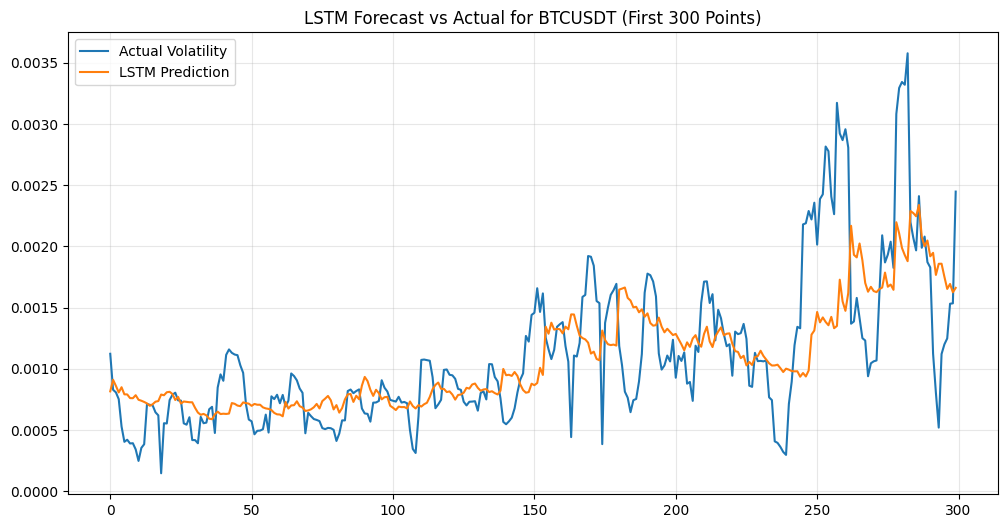

In [ ]:
# RUN BTC RESULTS
# 1. Load the best saved model
model.load_state_dict(torch.load("btc_logvol_best_lstm_model.pth"))

# 2. Evaluate
preds, acts = evaluate_and_plot(model, btc_test_dl, "BTCUSDT")


1. Calculating Global Importance (Streaming)...
   Baseline MSE: 0.214548


Features:   0%|          | 0/20 [00:00<?, ?it/s]


2. Analyzing Regime Stability (Streaming)...
   High Vol Threshold (>80%): -6.35733
   Low Vol Threshold (<50%):  -6.88676


Regime Analysis:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-3060958810.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_series.head(10).values, y=imp_series.head(10).index, palette='viridis')


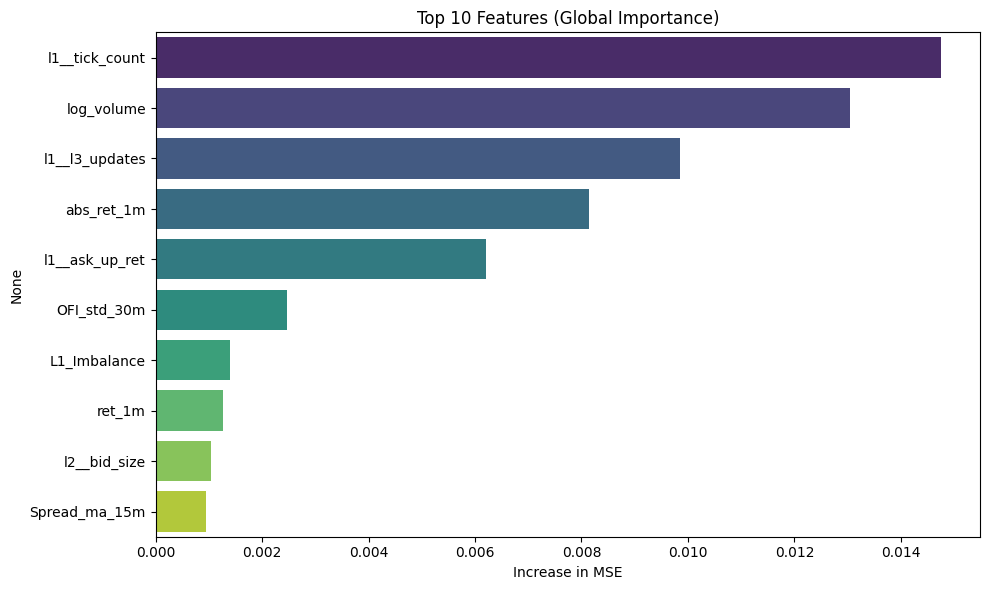

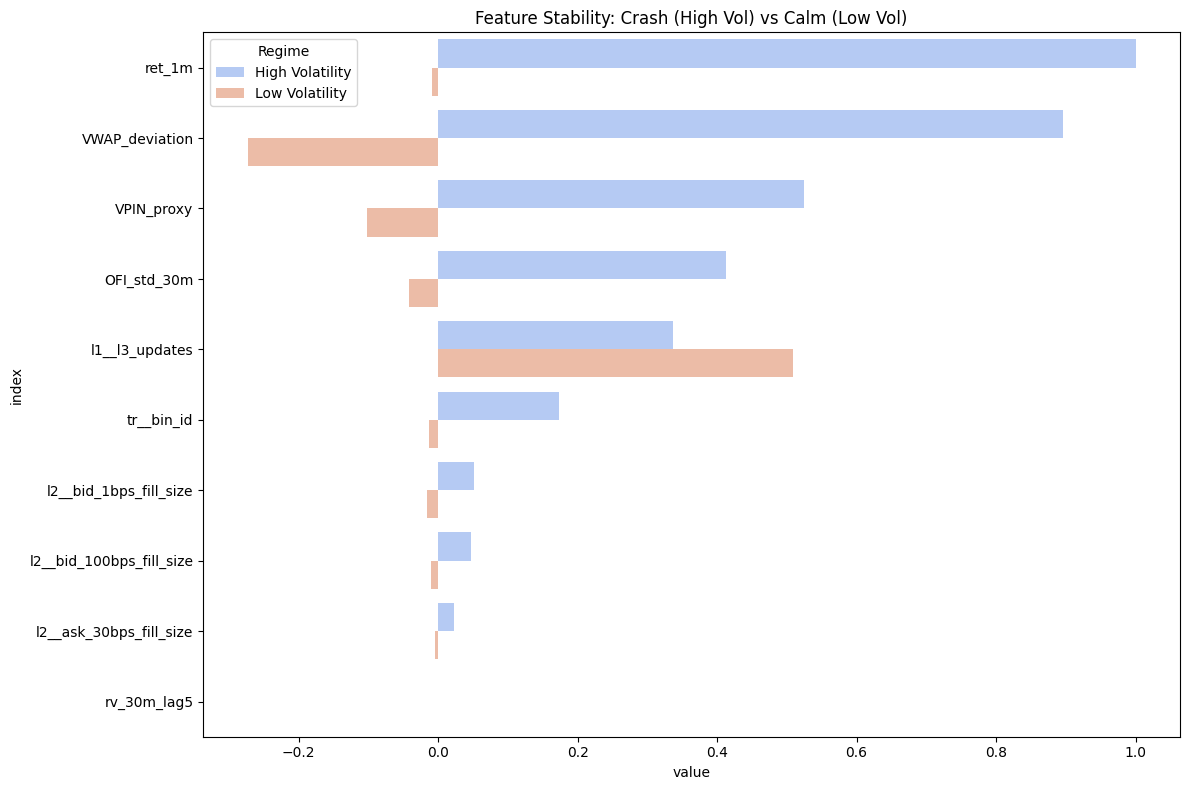

In [ ]:
# --- EXECUTE ---
global_imp = calculate_streaming_importance(model, btc_test_dl, btc_best_features)
regime_df = analyze_regime_stability_streaming(model, btc_test_dl, btc_best_features)

plot_results(global_imp, regime_df)

 BTC GROUP ANALYSIS 

Calculating Group-Level Importance...
   Baseline MSE: 0.214548


Analyzing Groups:   0%|          | 0/5 [00:00<?, ?it/s]


BTC Group Rankings:
Trade Intensity                3.229100e-02
Returns (Momentum)             2.477468e-02
Order Flow (Microstructure)    3.552657e-03
Volatility (History)           7.251363e-07
Liquidity (Order Book)        -7.034449e-04
dtype: float64


/tmp/ipython-input-2027406132.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_series.values, y=imp_series.index, palette='viridis')


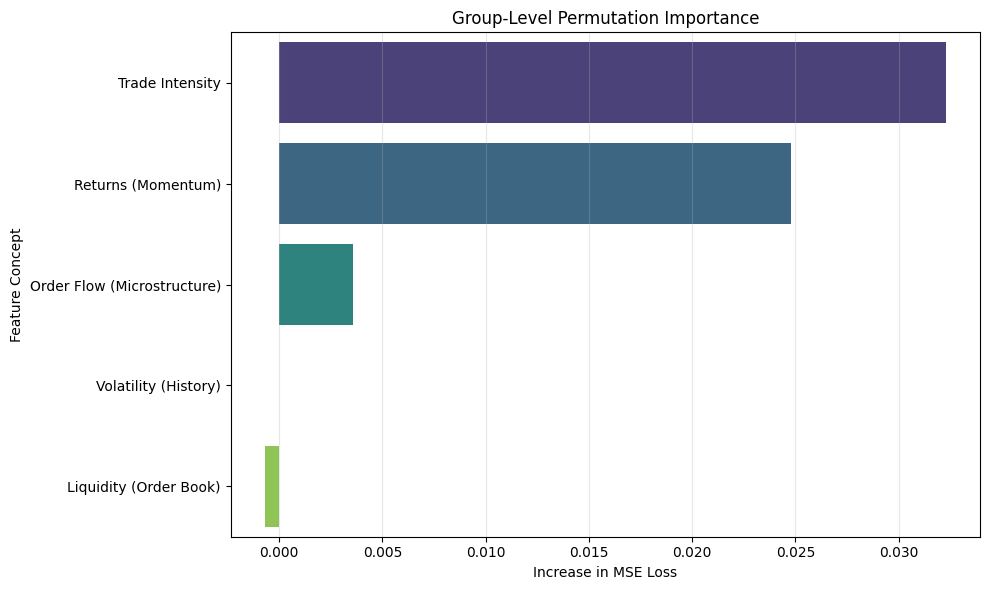

In [ ]:

# ==========================================
# 4. Execute for BTC
# ==========================================
print(f"{'='*30}\n BTC GROUP ANALYSIS \n{'='*30}")

# Run Calculation
btc_group_imp = calculate_group_importance(
    model,
    btc_test_dl,
    btc_best_features, # Ensures we only check features actually used in BTC model
    FEATURE_GROUPS
)

# Print & Plot
print("\nBTC Group Rankings:")
print(btc_group_imp)
plot_group_results(btc_group_imp, title="Group-Level Permutation Importance")

Running Inference on ETH Test Set (Inverse Transforming)...

FINAL RESULTS (Real Volatility Scale):
   RMSE: 0.000824
   MAE:  0.000521
   R^2:  0.489729


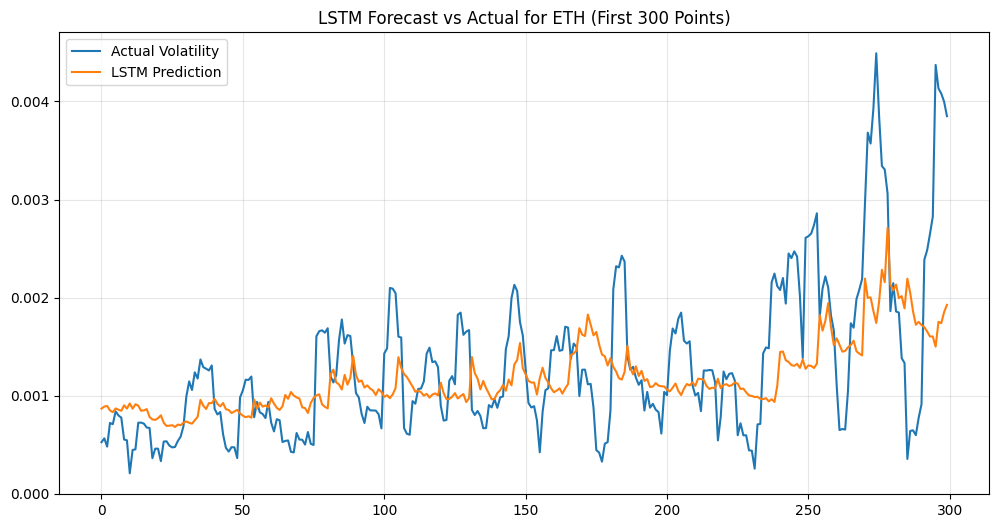

In [ ]:
# RUN ETH RESULTS
# 1. Load the best saved model
model.load_state_dict(torch.load("eth_logvol_best_lstm_model.pth"))

# 2. Evaluate
preds, acts = evaluate_and_plot(model, eth_test_dl, "ETH")


1. Calculating Global Importance (Streaming)...
   Baseline MSE: 0.191294


Features:   0%|          | 0/20 [00:00<?, ?it/s]


2. Analyzing Regime Stability (Streaming)...
   High Vol Threshold (>80%): -6.09514
   Low Vol Threshold (<50%):  -6.61415


Regime Analysis:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-3060958810.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_series.head(10).values, y=imp_series.head(10).index, palette='viridis')


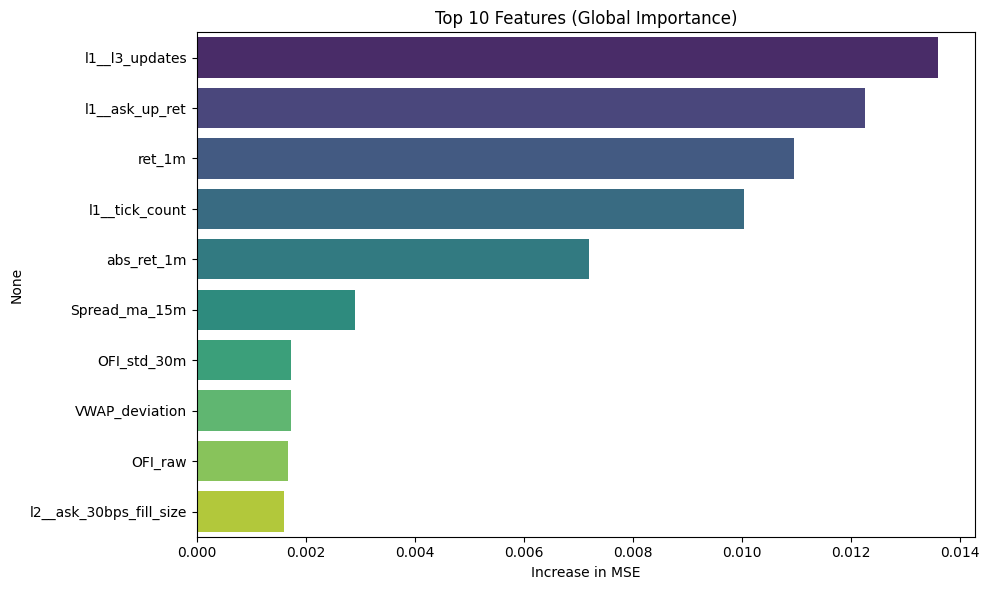

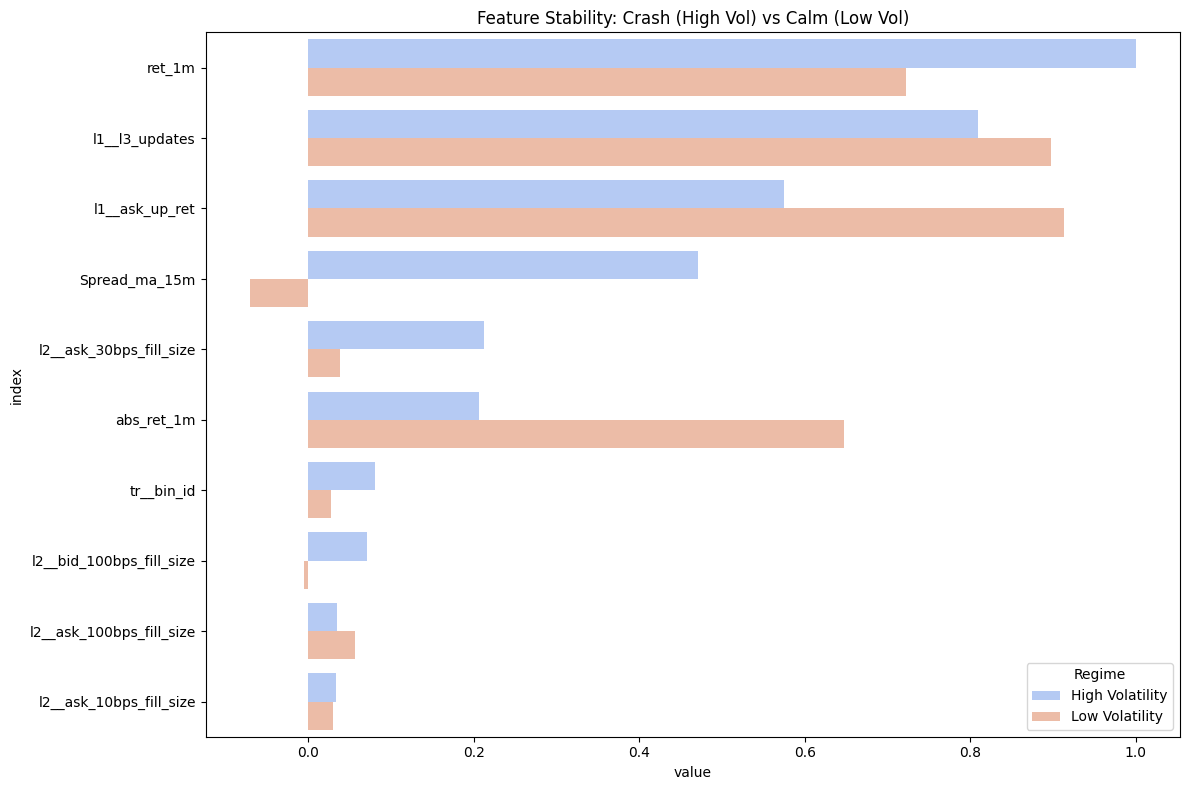

In [ ]:

global_imp = calculate_streaming_importance(model, eth_test_dl, eth_best_features)
regime_df = analyze_regime_stability_streaming(model, eth_test_dl, eth_best_features)

plot_results(global_imp, regime_df)

 ETH GROUP ANALYSIS 

Calculating Group-Level Importance...
   Baseline MSE: 0.191294


Analyzing Groups:   0%|          | 0/5 [00:00<?, ?it/s]


ETH Group Rankings:
Returns (Momentum)             0.048219
Trade Intensity                0.031911
Liquidity (Order Book)         0.004891
Order Flow (Microstructure)    0.004375
Volatility (History)           0.001508
dtype: float64


/tmp/ipython-input-2027406132.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_series.values, y=imp_series.index, palette='viridis')


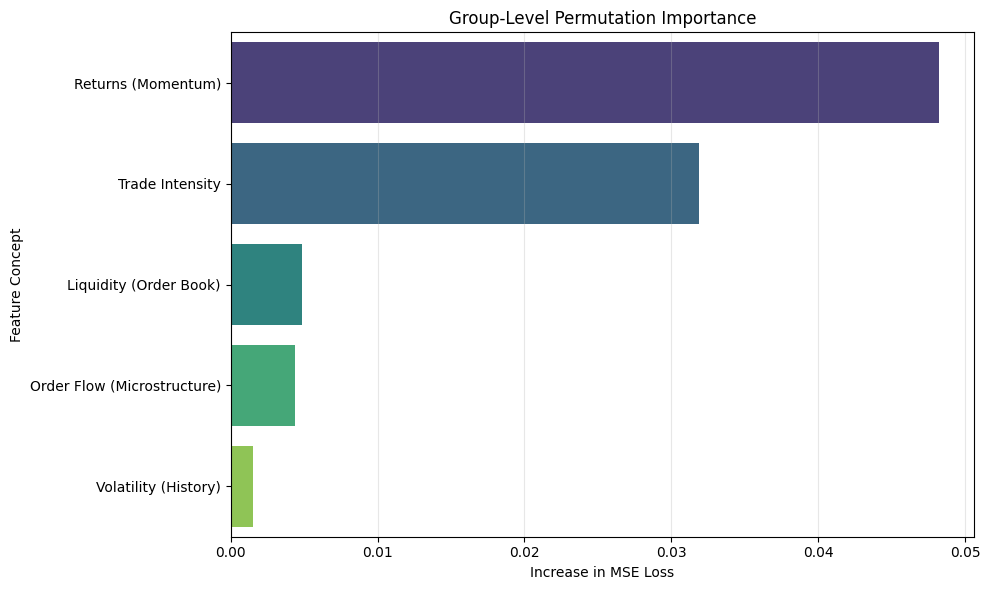

In [ ]:

# ==========================================
# 4. Execute for ETH
# ==========================================
print(f"{'='*30}\n ETH GROUP ANALYSIS \n{'='*30}")

# Run Calculation
eth_group_imp = calculate_group_importance(
    model,
    eth_test_dl,
    eth_best_features,
    FEATURE_GROUPS
)

# Print & Plot
print("\nETH Group Rankings:")
print(eth_group_imp)
plot_group_results(eth_group_imp, title="Group-Level Permutation Importance")